# Classification Trees and Random Forests

#### Jessica Morrise

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cross_validation import train_test_split
import random

Read in and do basic cleaning on the data.

In [3]:
def read_titanic_data():
    '''
    Reads and cleans passenger data from the Titanic dataset
    Returns:
    data - array of titanic data samples
    col_names - array of string titles of titanic data columns
    is_categorical - array of booleans where 'True' indicates that the corresponding column is categorical
    '''
    titanic_data = pd.read_csv('titanic.csv').drop(['Name','Cabin','Body','Ticket','Boat','home.dest'], axis=1)
    titanic_data['Age'] = titanic_data['Age'].fillna(titanic_data['Age'].median())
    titanic_data.dropna(inplace=True)
    survived = np.array(titanic_data['Survived'])
    titanic_data.drop('Survived',axis=1,inplace=True)
    return np.array(titanic_data), survived, np.array(titanic_data.columns), np.array([True, True, False, False, False,False,True])

data, survived, col_names, categorical = read_titanic_data()
train_idx, test_idx = train_test_split(np.arange(data.shape[0]), test_size=150)
train_data = data[train_idx,:]
train_labels = survived[train_idx]
test_data = data[test_idx,:]
test_labels = survived[test_idx]

This function defines the Gini impurity.

In [4]:
def gini(D_classes, classes):
    K = len(classes)
    N = len(D_classes)
    N_k = np.array([np.sum(D_classes==classes[k]) for k in xrange(K)])
    G = 1 - np.sum((N_k/float(N))**2)
    return G

This function splits the data on feature $p$. The argument _cat_ denotes whether or not feature $p$ is a categorical feature. 

In [5]:
def split(D,D_labels, p, x, cat=False):
    '''
    data: numpy array of data, where each row is a sample
    and each column is a feature
    p: index of feature to split on
    x: value of feature p to split on
    cat: is categorical (T/F)
    '''
    d_p = D[:,p]
    if cat:
        D1 = D[d_p == x,:]
        D2 = D[d_p != x,:]
        labels_1 = D_labels[d_p==x]
        labels_2 = D_labels[d_p!=x]
    else:
        D1 = D[d_p <= x, :]
        D2 = D[d_p > x, :]
        labels_1 = D_labels[d_p<=x]
        labels_2 = D_labels[d_p > x]

    return D1, D2, labels_1, labels_2

This function computes the information gain of a split. To discourage bad splits, we return a negative information gain for any split where all of the data ends up on the same side.

In [10]:
def info_gain(D,D_labels,p,x,cat=False):
    classes = list(set(D_labels))
    N = float(D.shape[0])
    I = gini(D_labels, classes)
    D1, D2, labels_1, labels_2 = split(D,D_labels,p,x,cat=cat)
    if D1.shape[0] == 0 or D2.shape[0] == 0:
        return -9999
    I -= (D1.shape[0]/N)*gini(labels_1,classes)
    I -= (D2.shape[0]/N)*gini(labels_2,classes)
    #print "p =",p,",x =",x,",I =",I
    return I

This function chooses the optimal split of dataset _D_ in order to maximize the information gain. The argument _cat_ is an array of boolean values with the same number of elements as the number of features of D, and the $i^{th}$ element of _cat_ indicates whether feature $p_i$ is a categorical feature. If _cat_ is not given, then we assume that no features are categorical.

In [7]:
def optimal_split(D,D_labels,cat=None,split_on=None):
    N, M = D.shape
    if cat is None:
        cat = np.array([False]*M)
    if split_on is None:
        split_on = np.arange(M)
    gains_max = -np.ones(M)
    x_max = np.empty(M, dtype=object)
    for p in split_on:
        x_vals = list(set(D[:,p]))
        gains = [info_gain(D,D_labels,p,x,cat[p]) for x in x_vals]
        gains_max[p] = max(gains)
        x_max[p] = x_vals[np.argmax(gains)]
    best_p = np.argmax(gains_max)
    best_x = x_max[best_p]
    d1,d2,l1,l2 = split(D,D_labels,best_p,best_x,cat[best_p])
    return best_p,best_x

This is a Node class!

In [8]:
class Node(object):
    def __init__(self, max_depth, gini_tol, depth=1, min_samples=2):
        self.label = None
        self.depth = depth
        self.max_depth = max_depth
        self.tol = gini_tol
        self.min_samples = min_samples
          
    def __str__(self):
        # Recursively generate a string describing the tree. yeah, this is really cool.
        s = ''.join(['    ']*(self.depth-1))
        s += "Depth %d/%d: "%(self.depth,self.max_depth)
        if self.label is not None:
            s +=  "Label = "+str(self.label)+"\n"
        else:
            s += "Split on feature "+self.col_names[self.p]+" = "+str(self.x)+str("\n")
            s += str(self.leftchild)
            s += str(self.rightchild)
        return s
        
    def train(self, D, y, col_names=None, categorical=None, random_split=None):
        M = D.shape[1] #number of columns
        #set column names
        if col_names is not None:
            self.col_names = col_names
        else:
            self.col_names = [str(i) for i in xrange(M)]
        
        #determine which columns are categorical
        if categorical is not None:
            self.cat = categorical
        else:
            self.cat = np.array([False]*M)
        
        #set random split. Defaults to using all M columns.
        if random_split is None:
            self.split_on = np.arange(M)
        elif hasattr(random_split, '__iter__'):
            self.split_on = random_split
        else:
             self.split_on = self.get_random_split(random_split,M)  
        
        #Calculate Gini impurity, and decide whether to keep splitting
        G = gini(y,list(set(y)))
        if G < self.tol or self.depth >= self.max_depth:
            self.label = np.argmax(np.bincount(y))
            return
        
        #split the node
        self.p, self.x = optimal_split(D.copy(),y.copy(),cat=self.cat,split_on=self.split_on)
        D1,D2,y1,y2 = split(D,y,self.p,self.x,self.cat[self.p])
        if y1.size<self.min_samples or y2.size<self.min_samples:
            #... but don't split it if a child node would be too small
            self.label = np.argmax(np.bincount(y))
            return
        self.leftchild = Node(self.max_depth,self.tol,depth=self.depth+1,min_samples=self.min_samples)
        self.leftchild.train(D1,y1,self.col_names,self.cat,self.split_on)
        self.rightchild = Node(self.max_depth,self.tol,depth=self.depth+1,min_samples=self.min_samples)
        self.rightchild.train(D2,y2,self.col_names,self.cat,self.split_on)
            
    def get_random_split(self,r,M):
        if r > M or r < 2:
            raise ValueError('r must be in the range 2<=r<=M')
        return random.sample(xrange(M),r)
        
    def classify(self,sample):
        # Classify a single sample
        if self.label is not None:
            return self.label
        else:
            split_val = sample[self.p]
            if split_val <= self.x:
                return self.leftchild.classify(sample)
            else:
                return self.rightchild.classify(sample)
            
    def classify_many(self,samples):
        # Classify an array of samples
        sample_labels = np.zeros(samples.shape[0])
        for i,s in enumerate(samples):
            sample_labels[i] = self.classify(samples[i])
        return sample_labels
    
    def accuracy(self,samples,actual_labels):
        predicted_labels = self.classify_many(samples)
        incorrect_labels = predicted_labels.astype(bool)^actual_labels.astype(bool)
        correct_count = actual_labels.size-np.sum(incorrect_labels)
        accuracy = correct_count/float(actual_labels.size)
        return accuracy

Here we train a tree with no random splits, i.e. we allow the nodes to split on any of the data columns.

In [12]:
train_accuracy = []
test_accuracy = []
max_depth = 30
for i in xrange(1,max_depth):
    tree = Node(i,.1)
    tree.train(train_data,train_labels,col_names,categorical,random_split=None)
    train_accuracy.append(1-tree.accuracy(train_data, train_labels))
    test_accuracy.append(1-tree.accuracy(test_data,test_labels))

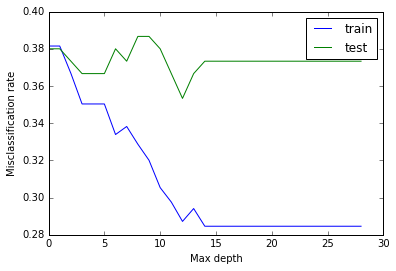

In [13]:
plt.plot(np.arange(max_depth-1),train_accuracy,label='train')
plt.plot(np.arange(max_depth-1),test_accuracy,label='test')
plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Misclassification rate')
plt.show()

When we allow the nodes to split on only four features, the results are much different. The performance on the test data seems to much more closely follow the performance on the test data. We don't do as well on the training data, but on the test data we actually do much better!

In [20]:
print "Feature names:",col_names

Feature names: ['Pclass' 'Sex' 'Age' 'Sibsp' 'Parch' 'Fare' 'Embarked']


In [32]:
train_accuracy = []
test_accuracy = []
max_depth = 30
for i in xrange(1,max_depth):
    tree = Node(i,.1)
    # Split on age, sex, sibsp, fare
    tree.train(train_data,train_labels,col_names,categorical,random_split=np.array([1.,2.,3.,5.]))
    train_accuracy.append(1-tree.accuracy(train_data, train_labels))
    test_accuracy.append(1-tree.accuracy(test_data,test_labels))

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: compari

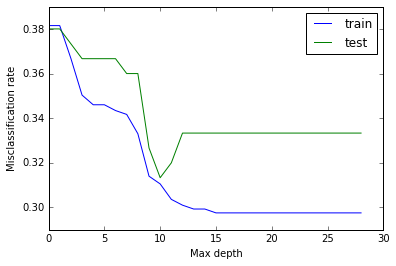

In [33]:
plt.plot(np.arange(max_depth-1),train_accuracy,label='train')
plt.plot(np.arange(max_depth-1),test_accuracy,label='test')
plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Misclassification rate')
plt.show()

These are the results if we leave out some important features such as 'Sex' and 'Pclass'. We actually do amazing on the training data, and a little worse on the test data.

In [34]:
train_accuracy = []
test_accuracy = []
max_depth = 30
for i in xrange(1,max_depth):
    tree = Node(i,.1)
    # split on sibsp, parch, 
    tree.train(train_data,train_labels,col_names,categorical,random_split=np.array([2., 3., 5., 6.]))
    train_accuracy.append(1-tree.accuracy(train_data, train_labels))
    test_accuracy.append(1-tree.accuracy(test_data,test_labels))

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: compari

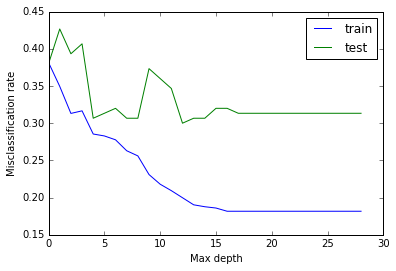

In [35]:
plt.plot(np.arange(max_depth-1),train_accuracy,label='train')
plt.plot(np.arange(max_depth-1),test_accuracy,label='test')
plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Misclassification rate')
plt.show()

And lo and behold, we print one of our trees.

In [39]:
tree = Node(8,.1)
tree.train(train_data,train_labels,col_names,categorical,random_split=None)
print tree

Depth 1/8: Split on feature Sex = male
    Depth 2/8: Split on feature Age = 9.0
        Depth 3/8: Split on feature Sibsp = 2
            Depth 4/8: Label = 1
            Depth 4/8: Split on feature Age = 3.0
                Depth 5/8: Label = 0
                Depth 5/8: Label = 0
        Depth 3/8: Split on feature Pclass = 1
            Depth 4/8: Split on feature Age = 54.0
                Depth 5/8: Split on feature Fare = 25.5875
                    Depth 6/8: Label = 0
                    Depth 6/8: Split on feature Fare = 31.0
                        Depth 7/8: Split on feature Age = 50.0
                            Depth 8/8: Label = 0
                            Depth 8/8: Label = 1
                        Depth 7/8: Split on feature Sibsp = 0
                            Depth 8/8: Label = 0
                            Depth 8/8: Label = 0
                Depth 5/8: Label = 0
            Depth 4/8: Split on feature Embarked = C
                Depth 5/8: Split on feature Par

### Random Forests

This class uses our previous Node class to implement a random forest.

In [45]:
class Forest(object):
    
    def __init__(self, max_depth, gini_tol, num_trees):
        self.trees = []
        self.N = num_trees
        for i in xrange(self.N):
            self.trees.append(Node(max_depth, gini_tol))
        self.tol = gini_tol
        self.max_depth = max_depth
        
    def __str__(self):
        s = '\n%d Trees\n'%(self.N)
        for i,node in enumerate(self.trees):
            s += 'Tree #%d:\n'%(i+1)
            s += str(node)+'\n'
        return s
        
    def train(self, data, labels, col_names=None, categorical=None, num_vars=None):
        if num_vars is None:
            num_vars = int(data.shape[1]**0.5)+1
            print num_vars
        self.r = num_vars
        count = 1
        for node in self.trees:
            print "\rtraining tree #",count,'/',self.N,
            node.train(data, labels, col_names, categorical, self.r)
            count += 1
            
    def classify(self, sample):
        predictions = []
        for node in self.trees:
            predictions.append(node.classify(sample))
        return np.argmax(np.bincount(predictions))
    
    def classify_many(self,samples):
        sample_labels = np.zeros(samples.shape[0])
        for i,s in enumerate(samples):
            sample_labels[i] = self.classify(samples[i])
        return sample_labels
    
    def accuracy(self,samples,actual_labels):
        predicted_labels = self.classify_many(samples)
        incorrect_labels = predicted_labels.astype(bool)^actual_labels.astype(bool)
        correct_count = actual_labels.size-np.sum(incorrect_labels)
        accuracy = correct_count/float(actual_labels.size)
        return accuracy

We create a random forest with 5 trees and a max depth of 30.

In [52]:
forest = Forest(20,.1,5)
forest.train(train_data,train_labels,col_names=col_names,categorical=categorical,num_vars=3)
print '\n',forest

training tree # 5 / 5 

5 Trees
Tree #1:
Depth 1/20: Split on feature Fare = 15.1
    Depth 2/20: Split on feature Age = 16.0
        Depth 3/20: Split on feature Fare = 13.4167
            Depth 4/20: Split on feature Age = 13.0
                Depth 5/20: Split on feature Age = 2.0
                    Depth 6/20: Split on feature Age = 0.8333
                        Depth 7/20: Label = 1
                        Depth 7/20: Label = 0
                    Depth 6/20: Label = 1
                Depth 5/20: Split on feature Fare = 9.225
                    Depth 6/20: Split on feature Fare = 7.8542
                        Depth 7/20: Split on feature Fare = 7.7333
                            Depth 8/20: Label = 1
                            Depth 8/20: Label = 0
                        Depth 7/20: Split on feature Fare = 8.5167
                            Depth 8/20: Label = 1
                            Depth 8/20: Label = 0
                    Depth 6/20: Label = 0
            Depth 4/20

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a boolean instead of an integer will result in an error in the future
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a boolean instead of an integer will result in an error in the future
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a boolean instead of an integer will resu

Accuracy for this random forest isn't actually much better than it was for a single tree. 

In [55]:
print forest.accuracy(test_data, test_labels.astype(int))

0.653333333333


Finally, we train random forests with max depth of 20, increasing the number of trees by 2 each time until we reach 60.

In [56]:
forest_train_accuracy = []
forest_test_accuracy = []
max_depth = 20
n_trees = 60
for i in xrange(1,n_trees,2):
    forest = Forest(max_depth,.1,i)
    forest.train(train_data,train_labels,col_names,categorical,4)
    forest_train_accuracy.append(1-forest.accuracy(train_data, train_labels))
    forest_test_accuracy.append(1-forest.accuracy(test_data,test_labels))

training tree # 59 / 59


/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a boolean instead of an integer will result in an error in the future
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a boolean instead of an integer will result in an error in the future
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a boolean instead of an integer will resu

There isn't much of a downward trend in the misclassification rate as we increase the number of trees. This is probably because of the simplicity of our data - the main features of the data can be captured by just one tree.

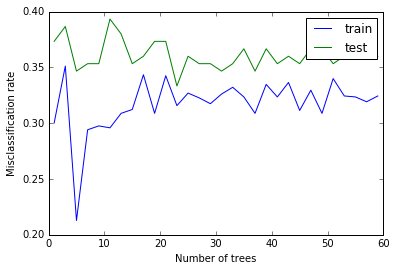

In [58]:
plt.plot(np.arange(1,n_trees,2),forest_train_accuracy,label='train')
plt.plot(np.arange(1,n_trees,2),forest_test_accuracy,label='test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('Misclassification rate')
plt.show()